# SMYLE Gross Primary Productivity (GPP) potential predictability

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io
from SMYLEutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [66]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

### Read in CLM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)

In [5]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [6]:
# SMYLE-NOV data
# process all 20 ensemble members, all start dates dates from 1970-2018:
# these only need to be defined once, with io for each initialized month handled below
field = 'GPP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
chunk = {}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

5.202259752

In [7]:
%%time
# convert monthly data to seasonal data
smyle11 = cal.mon_to_seas_dask(smyle11).persist()

CPU times: user 12.2 s, sys: 158 ms, total: 12.3 s
Wall time: 13.2 s


In [8]:
%%time
# SMYLE-FEB data
# process all 20 ensemble members, Feb dates from 1970-2018:
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle02 data set = '+str(smyle02.nbytes/1e9)+ ' GB') #GB

smyle02 data set = 5.202259752 GB
CPU times: user 59.8 s, sys: 20.6 s, total: 1min 20s
Wall time: 1min 23s


In [9]:
%%time
# convert monthly data to seasonal data
smyle02 = cal.mon_to_seas_dask(smyle02).persist()

CPU times: user 14.1 s, sys: 194 ms, total: 14.3 s
Wall time: 14.6 s


In [10]:
%%time
# SMYLE-MAY data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('data set = '+str(smyle05.nbytes/1e9)+ ' GB') #GB

data set = 5.202259752 GB
CPU times: user 1min 2s, sys: 20.3 s, total: 1min 22s
Wall time: 1min 27s


In [11]:
%%time
# convert monthly data to seasonal data
smyle05 = cal.mon_to_seas_dask(smyle05).persist()

CPU times: user 15.7 s, sys: 261 ms, total: 16 s
Wall time: 16.3 s


In [12]:
%%time
# SMYLE-AUG data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle08 data set = '+str(smyle08.nbytes/1e9)+ ' GB') #GB

smyle08 data set = 5.202259752 GB
CPU times: user 1min 6s, sys: 20.6 s, total: 1min 26s
Wall time: 1min 31s


In [13]:
%%time
# convert monthly data to seasonal data
smyle08 = cal.mon_to_seas_dask(smyle08).persist()

CPU times: user 14.3 s, sys: 144 ms, total: 14.4 s
Wall time: 15.2 s


### Regrid Hindcast data

In [14]:
## Define 3x3 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,93,3),'lon':np.arange(0,360,3)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [15]:
smyle11 = regrid.add_grid_bounds(smyle11)
smyle02 = regrid.add_grid_bounds(smyle02)
smyle05 = regrid.add_grid_bounds(smyle05)
smyle08 = regrid.add_grid_bounds(smyle08)

In [16]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(smyle11, destgrid, 'conservative', periodic=True)

In [19]:
%%time
smyle11_da = regrid_cam1deg(smyle11.GPP,skipna=True, na_thres=0.5).load()
smyle11_time = smyle11.time.load()
smyle02_da = regrid_cam1deg(smyle02.GPP,skipna=True, na_thres=0.5).load()
smyle02_time = smyle02.time.load()
smyle05_da = regrid_cam1deg(smyle05.GPP,skipna=True, na_thres=0.5).load()
smyle05_time = smyle05.time.load()
smyle08_da = regrid_cam1deg(smyle08.GPP,skipna=True, na_thres=0.5).load()
smyle08_time = smyle08.time.load()

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc

CPU times: user 1min 3s, sys: 47.1 s, total: 1min 50s
Wall time: 1min 56s


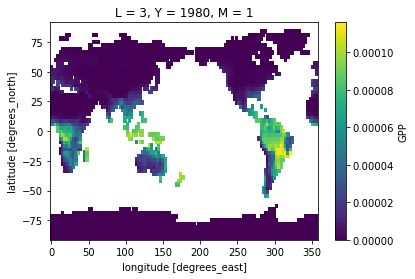

In [20]:
smyle11_da.isel(Y=10,L=0,M=0).plot();

### DataArrays are manageable size now (and in memory), so you could release Dask cluster 

In [21]:
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'

ds1 = smyle11_da.to_dataset()
ds1['time'] = smyle11_time
ds1.to_netcdf(outdir+'SMYLE11_GPP_seas_3x3.nc')

ds1 = smyle02_da.to_dataset()
ds1['time'] = smyle02_time
ds1.to_netcdf(outdir+'SMYLE02_GPP_seas_3x3.nc')

ds1 = smyle05_da.to_dataset()
ds1['time'] = smyle05_time
ds1.to_netcdf(outdir+'SMYLE05_GPP_seas_3x3.nc')

ds1 = smyle08_da.to_dataset()
ds1['time'] = smyle08_time
ds1.to_netcdf(outdir+'SMYLE08_GPP_seas_3x3.nc')

In [ ]:
## Retrieve GPP-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_GPP_seas_3x3.nc')
smyle11_da = smyle11_seas['GPP']
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_GPP_seas_3x3.nc')
smyle02_da = smyle02_seas['GPP']
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_GPP_seas_3x3.nc')
smyle05_da = smyle05_seas['GPP']
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_GPP_seas_3x3.nc')
smyle08_da = smyle08_seas['GPP']

### Get results from CLM5 SMYLE-TRENDY for potential predictability
/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/

In [22]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.'+field+'.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
ds_clm['time']

<xarray.DataArray 'time' (time: 708)>
array([cftime.DatetimeNoLeap(1960, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00

In [23]:
ds_clm.GPP

<xarray.DataArray 'GPP' (time: 708, lat: 192, lon: 288)>
[39149568 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

### Compute OBS seasonal averages

In [24]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [25]:
clm_seas = obs_convert_mon_to_seas(ds_clm[field],field)

In [26]:
## convert OBS to anomalies from 1972-2017
clm_seas = clm_seas - clm_seas.sel(year=slice(1972,2018)).mean('year')

In [27]:
clm_seas = clm_seas.sel(year=slice(1960,2018))
clm_seas

<xarray.Dataset>
Dimensions:  (year: 59, lon: 288, lat: 192, season: 4)
Coordinates:
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017 2018
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    GPP      (season, year, lat, lon) float64 nan nan nan nan ... nan nan nan

### Regrid

In [28]:
clm_seas = regrid.add_grid_bounds(clm_seas)

In [29]:
%%time
clm_recon = regrid_cam1deg(clm_seas.GPP,skipna=True, na_thres=0.5)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 196 ms, sys: 55.1 ms, total: 252 ms
Wall time: 260 ms


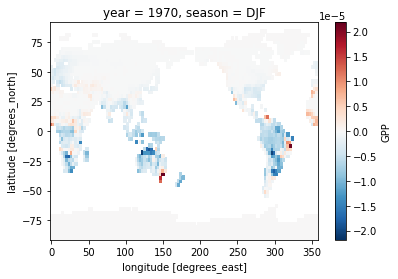

In [30]:
clm_recon.isel(year=10,season=0).plot()

## Get CESM2-LE Data

In [31]:
import intake

catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
cesm2data = col.search(component='lnd', 
                       variable=['GPP'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'], 
                       forcing_variant='smbb')

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [32]:
## The following is needed as a workaround for this issue with intake-esm:
## https://github.com/intake/intake-esm/issues/343
cesm2data.df = cesm2data.df.sort_values(by=['time_range'])

# Test that it gets timestamps in order:
#cesm2data.df[cesm2data.df.experiment == 'historical']

In [33]:
%%time
## Use preprocessor to return mid-month time
def preproc(ds):
    ds = cal.time_set_midmonth(ds,'time')
    return ds

dask.config.set(**{'array.slicing.split_large_chunks': True})
dsets = cesm2data.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 2s, sys: 2.11 s, total: 1min 4s
Wall time: 1min 26s


In [34]:
dsets.keys()

dict_keys(['lnd.ssp370.clm2.h2.smbb.GPP', 'lnd.historical.clm2.h1.smbb.GPP', 'lnd.ssp370.clm2.h1.smbb.GPP', 'lnd.ssp370.clm2.h0.smbb.GPP', 'lnd.historical.clm2.h0.smbb.GPP', 'lnd.historical.clm2.h2.smbb.GPP'])

In [37]:
# Compute CESM2-LE mean over 50 members:
cesm2_hist = dsets['lnd.historical.clm2.h0.smbb.GPP'].GPP
cesm2_ssp = dsets['lnd.ssp370.clm2.h0.smbb.GPP'].GPP
cesm2_gpp = xr.concat([cesm2_hist,cesm2_ssp],dim='time').mean('member_id').persist()

In [38]:
cesm2_gpp

<xarray.DataArray 'GPP' (time: 3012, lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(3012, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00

In [39]:
cesm2_gpp_seas = cesm2_gpp.rolling(time=3,min_periods=3, center=True).mean()

In [40]:
%%time
cesm2_gpp = regrid_cam1deg(cesm2_gpp_seas,skipna=True, na_thres=0.5)

CPU times: user 7.26 ms, sys: 1.07 ms, total: 8.34 ms
Wall time: 8.35 ms


/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


# Anomaly Correlation Plots

In [41]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11_da,smyle11_time,1972,2018)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02_da,smyle02_time,1972,2018)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05_da,smyle05_time,1972,2018)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08_da,smyle08_time,1972,2018)

In [42]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_time,clm_recon)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_time,clm_recon)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_time,clm_recon)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_time,clm_recon)

CPU times: user 4.56 s, sys: 733 ms, total: 5.29 s
Wall time: 5.55 s


In [43]:
# Mask Antarctica
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

In [44]:
# Zero out ACC where insignificant
siglvl = 0.1
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 915 ms, sys: 16.8 ms, total: 932 ms
Wall time: 975 ms


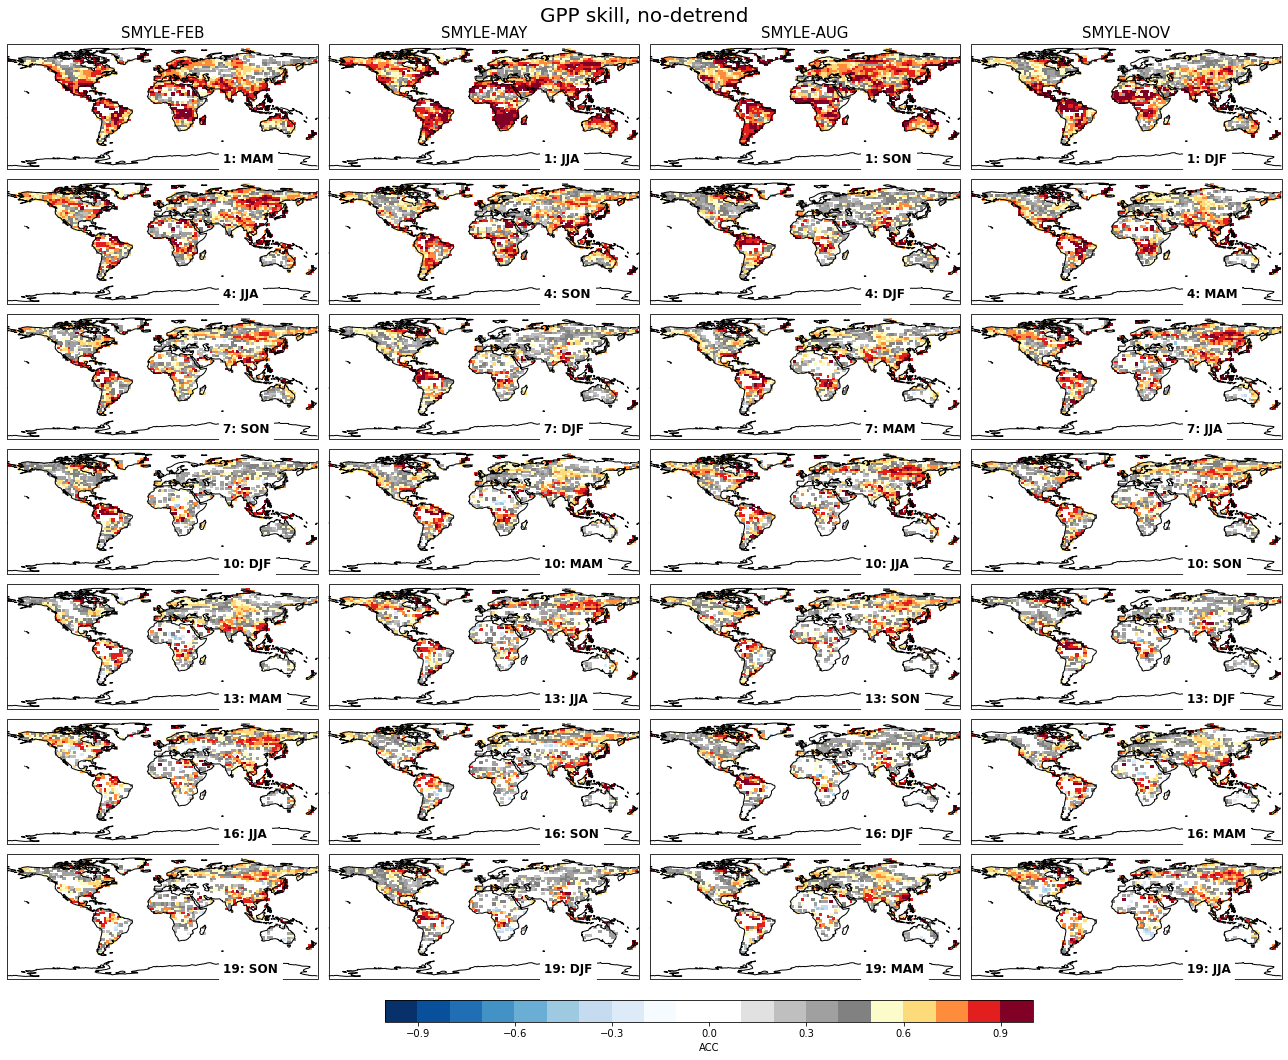

In [45]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*4+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*4+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*4+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*4+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
fig.suptitle('GPP skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')

### Use Linear Detrending

In [46]:
%%time
smyle11_skill = stat.leadtime_skill_seas(smyle11_anom,smyle11_time,clm_recon,detrend=True)
smyle02_skill = stat.leadtime_skill_seas(smyle02_anom,smyle02_time,clm_recon,detrend=True)
smyle05_skill = stat.leadtime_skill_seas(smyle05_anom,smyle05_time,clm_recon,detrend=True)
smyle08_skill = stat.leadtime_skill_seas(smyle08_anom,smyle08_time,clm_recon,detrend=True)

CPU times: user 53.3 s, sys: 4.23 s, total: 57.5 s
Wall time: 1min


In [47]:
# Mask Antarctica
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

In [48]:
# Zero out ACC where insignificant
siglvl = 0.1
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 925 ms, sys: 32.2 ms, total: 958 ms
Wall time: 985 ms


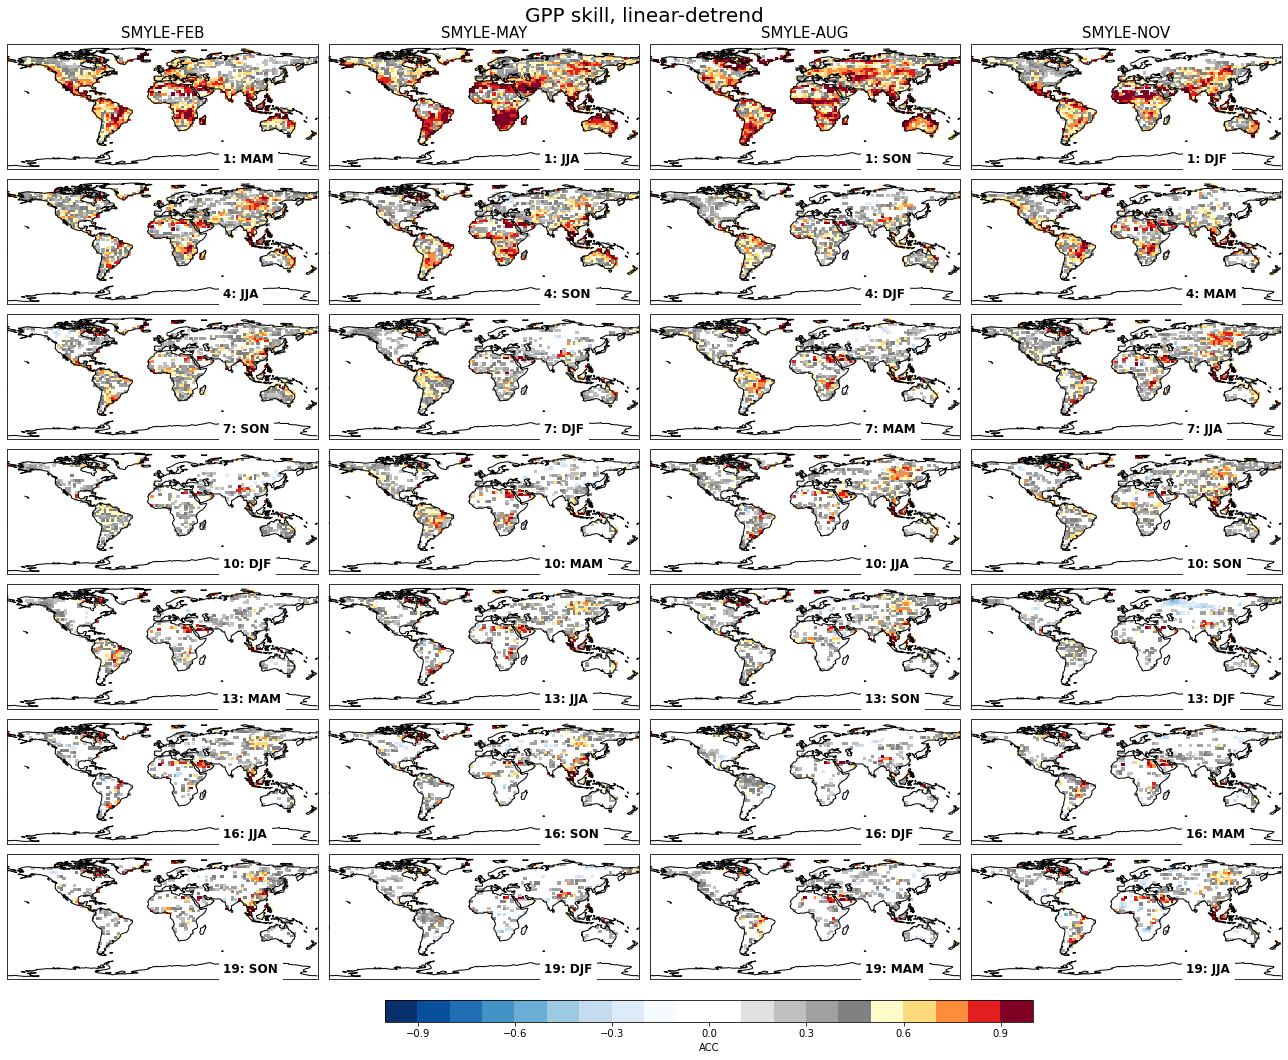

In [49]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*4+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*4+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*4+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*4+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
fig.suptitle('GPP skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')

## Deeper dive into high JJA skill over Siberia

CPU times: user 49.9 ms, sys: 1.05 ms, total: 50.9 ms
Wall time: 51 ms


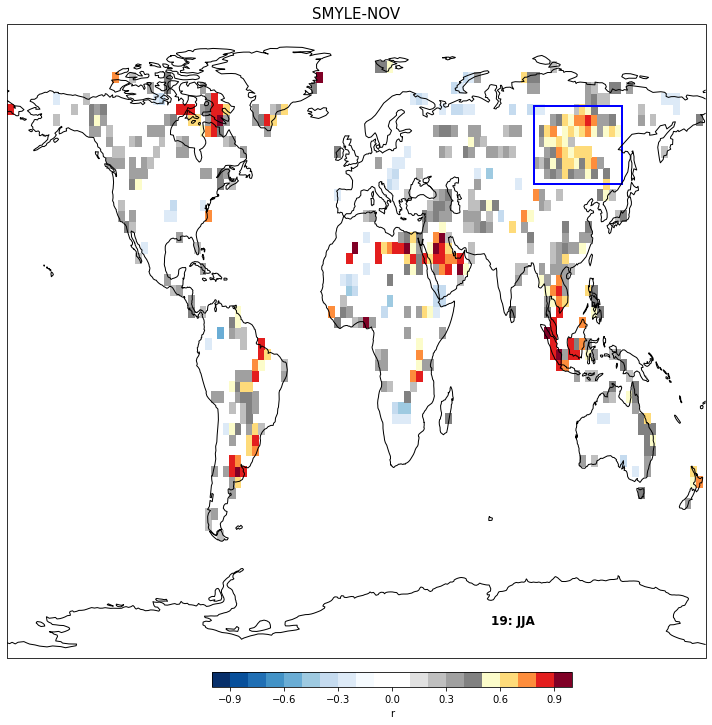

In [50]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(10,10))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],1,1,1,proj,cmap=cmap,cutoff=coff)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')

ax4.add_patch(mpatches.Rectangle(xy=[92, 45], width=45, height=22,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr4, cax=cbar_ax, label='r', orientation='horizontal')

In [51]:
# Siberia regional-average
region1lonlat = [92.,137.,45.,67.]  
region1title = 'Siberia'

tmp = clm_seas['GPP'].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
trendy_GPP = tmp.weighted(wgts).mean(("lon", "lat"))
trendy_raw_GPP = ds_clm['GPP'].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1])).weighted(wgts).mean(("lon", "lat"),skipna=True)

tmp = smyle11_anom.isel(L=6).mean('M').sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
smyle_GPP = tmp.weighted(wgts).mean(("lon", "lat"),skipna=True).rename({'Y':'time'})
smyle_GPP['time'] = smyle11.isel(L=6).time.dt.year.values

In [52]:
# CESM2-LE regional-average
keep = cesm2_gpp.time.dt.month==7
tmp = cesm2_gpp.isel(time=keep).sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
cesm2le_jja = tmp.weighted(wgts).mean(("lon", "lat")).load()
cesm2le_jja['time'] = tmp.time.dt.year.values
cesm2le_jja = cesm2le_jja - cesm2le_jja.sel(time=slice(1972,2018)).mean('time')

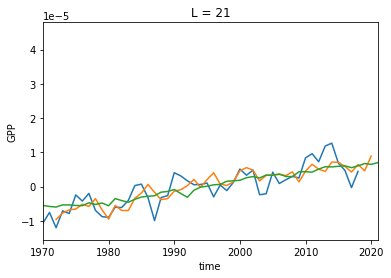

In [53]:
trendy_GPP.sel(season='JJA').plot(xlim=[1970,2021]);
smyle_GPP.plot()
cesm2le_jja.plot()

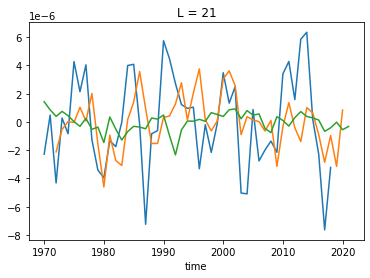

In [54]:
stat.detrend_linear(trendy_GPP.sel(season='JJA').sel(year=slice(1970,2021)),'year').plot();
stat.detrend_linear(smyle_GPP.sel(time=slice(1970,2021)),'time').plot();
stat.detrend_linear(cesm2le_jja.sel(time=slice(1970,2021)),'time').plot();

In [55]:
%%time
smyle11_reg = smyle11_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle11_reg = smyle11_reg.weighted(wgts).mean(("lon", "lat"))
smyle02_reg = smyle02_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle02_reg = smyle02_reg.weighted(wgts).mean(("lon", "lat"))
smyle05_reg = smyle05_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle05_reg = smyle05_reg.weighted(wgts).mean(("lon", "lat"))
smyle08_reg = smyle08_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
smyle08_reg = smyle08_reg.weighted(wgts).mean(("lon", "lat"))

CPU times: user 114 ms, sys: 21 ms, total: 135 ms
Wall time: 139 ms


In [56]:
%%time
smyle11_skill_reg = stat.leadtime_skill_seas(smyle11_reg,smyle11_time,trendy_GPP,detrend=True)
smyle02_skill_reg = stat.leadtime_skill_seas(smyle02_reg,smyle02_time,trendy_GPP,detrend=True)
smyle05_skill_reg = stat.leadtime_skill_seas(smyle05_reg,smyle05_time,trendy_GPP,detrend=True)
smyle08_skill_reg = stat.leadtime_skill_seas(smyle08_reg,smyle08_time,trendy_GPP,detrend=True)

CPU times: user 655 ms, sys: 4.5 ms, total: 659 ms
Wall time: 667 ms


### Create Persistence scores from autocorrelation of seasonal forced-CLM data

In [57]:
trendy_raw_GPP.sel(time=slice("1970","2019")).time

<xarray.DataArray 'time' (time: 588)>
array([cftime.DatetimeNoLeap(1970, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1970-01-15 00:00:00 ... 2018-12-15 00:00:00

In [58]:
trendy_3mrunmean = trendy_raw_GPP.rolling(time=3, center=True).mean().sel(time=slice("1970","2019"))

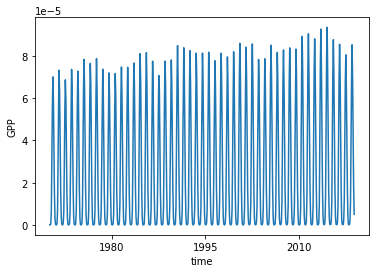

In [59]:
trendy_3mrunmean.plot();

Because GPP goes to zero each winter, it doesn't make sense to persist seasonal anomalies to match the same lead times as in SMYLE seasonal hindcasts. Instead, compute persistence scores by persisting JJA anomalies (corresponding to lead times of 9-months and 21-months).

In [60]:
import xskillscore as xs
trendy_jja =  trendy_3mrunmean.where(trendy_3mrunmean.time.dt.month==7).dropna('time')
trendy_jja_dt = stat.detrend_linear(trendy_jja, 'time')
trendy_jja_ac1 = xs.pearson_r(trendy_jja_dt,trendy_jja_dt.shift(time=1),'time',skipna=True)
trendy_jja_ac2 = xs.pearson_r(trendy_jja_dt,trendy_jja_dt.shift(time=2),'time',skipna=True)

cesm2_dt = stat.detrend_linear(cesm2le_jja.sel(time=slice(1970,2018)), 'time')
cesm2_dt['time'] = trendy_jja_dt['time']
cesm2_acc = xs.pearson_r(trendy_jja_dt,cesm2_dt,'time',skipna=True)
cesm2_rmse = xs.rmse(trendy_jja_dt,cesm2_dt,dim='time')/trendy_jja_dt.std('time')

CPU times: user 577 ms, sys: 103 ms, total: 680 ms
Wall time: 708 ms


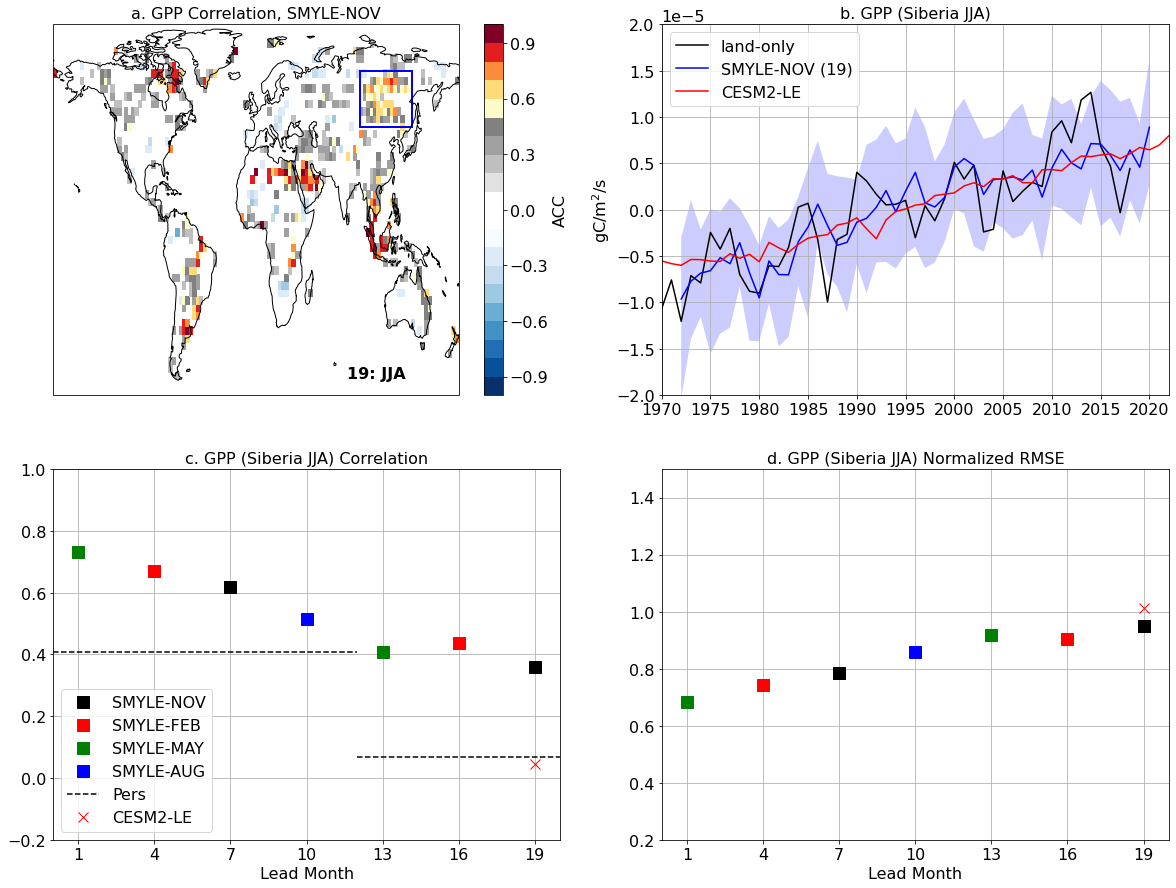

In [64]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(20,15))
nrow=2
ncol=2
plt.rcParams.update({'font.size': 16})

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=16
fweight='bold'
xloc = 80
yloc = -55

tmp = smyle11_skill.corr.isel(L=6).sel(lat=slice(-60,85))
ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp, tmp.lon, tmp.lat,
                                       ci,cmin,cmax,colstr[3],nrow,ncol,1,proj,cmap=cmap,cutoff=coff)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
ax1.add_patch(mpatches.Rectangle(xy=[92, 45], width=45, height=22,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))
ax1.set_title('a. GPP Correlation, SMYLE-NOV',loc='center',fontsize=fsize)
fig.colorbar(cntr1, ax=ax1, label='ACC')

ax2 = fig.add_subplot(nrow,ncol,2)
ax2.plot(trendy_GPP.year,trendy_GPP.sel(season='JJA'),color='k',label='land-only')
smyle11_time = smyle11.isel(L=6).time.dt.year.values
ax2.plot(smyle11_time,smyle11_reg.mean('M').isel(L=6),color='b',label='SMYLE-NOV (19)')
ymin = smyle11_reg.min('M').isel(L=6)
ymax = smyle11_reg.max('M').isel(L=6)
ax2.fill_between(smyle11_time,ymin,ymax,fc='b',alpha=0.2)
ax2.plot(cesm2le_jja.time,cesm2le_jja,color='r',label='CESM2-LE')
ax2.legend(loc='upper left')
ax2.set_xticks(np.arange(1970,2025,5))
ax2.grid(True)
ax2.set_xlim([1970,2022])
ax2.set_title('b. GPP (Siberia JJA)',loc='center',fontsize=fsize)
#ax2.set_xlabel('Year')
ax2.set_ylabel(r'gC/m$^2$/s')
ax2.set_ylim([-2e-5,2e-5])

ax3 = fig.add_subplot(nrow,ncol,3)
leadmon = smyle11_skill_reg.L
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
#ax3.set_ylabel('Correlation', fontsize=14)
ax3.set_title('c. GPP (Siberia JJA) Correlation',loc='center',fontsize=fsize)
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA').where(smyle11_skill_reg.pval<0.1),color='k',marker='s',ms=12,label='SMYLE-NOV',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA').where(smyle02_skill_reg.pval<0.1),color='r',marker='s',ms=12,label='SMYLE-FEB',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA').where(smyle05_skill_reg.pval<0.1),color='g',marker='s',ms=12,label='SMYLE-MAY',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA').where(smyle08_skill_reg.pval<0.1),color='b',marker='s',ms=12,label='SMYLE-AUG',linestyle='none')
ax3.plot([0,12],[trendy_jja_ac1,trendy_jja_ac1],color='k',linestyle='dashed',label='Pers')
ax3.plot([12,20],[trendy_jja_ac2,trendy_jja_ac2],color='k',linestyle='dashed')
ax3.plot(19,cesm2_acc,color='r',marker='x',label='CESM2-LE',linestyle='none',markersize=10)
ax3.legend(loc='lower left',ncol=1)
ax3.set_xticks(leadmon)
ax3.grid(True)
ax3.set_xlim([0,20])
ax3.set_ylim([-0.2,1])
ax3.set_xlabel('Lead Month')

ax4 = fig.add_subplot(nrow,ncol,4)
ax4.set_ylabel(r'', fontsize=14)
ax4.set_title('d. GPP (Siberia JJA) Normalized RMSE',loc='center',fontsize=fsize)
ax4.plot(leadmon,smyle11_skill_reg.nrmse.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle02_skill_reg.nrmse.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle05_skill_reg.nrmse.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle08_skill_reg.nrmse.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',ms=12,linestyle='none')
ax4.plot(19,cesm2_rmse,color='r',marker='x',linestyle='none',markersize=10)
ax4.set_xticks(leadmon)
ax4.grid(True)
ax4.set_xlim([0,20])
ax4.set_ylim([0.2,1.5])
ax4.set_xlabel('Lead Month')
plt.savefig('Fig11_GPP_Siberia_JJA.png')
